In [547]:
import argparse
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from jax.experimental.ode import build_odeint
import jax.numpy as np
from jax.random import PRNGKey
from jax import lax

import numpyro
import numpyro.distributions as dist
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

In [618]:
# (Could easily generalize this to flows between compartments)
def dx_dt(x, t, beta, gamma):
    """
    SIR equations. Real positive parameters `beta`, `gamma`,
    describe the infection rate and recovery rate.
    """
    S = x[0]
    I = x[1]
    R = x[2]
    n = S + I + R
    I_tot = x[3]
    dS_dt = - beta * S * I / n
    dI_dt = beta * S * I / n - gamma * I
    dR_dt = gamma * I
    dItot_dt = beta * S * I / n
    return np.stack([dS_dt, dI_dt, dR_dt, dItot_dt])

SIR_int = build_odeint(dx_dt, rtol=1e-5, atol=1e-3, mxstep=500)

def myBeta(mean, concentration):
    alpha = mean * concentration
    beta = concentration - alpha
    return dist.Beta(alpha, beta)

def model_deterministic(ts, beta=2.5/14, gamma=1.0/14, N=1e4, I_frac=0.01):
    x_init = N*np.array([1-I_frac, I_frac, 0, 0])
    theta = np.array([beta, gamma])
    return SIR_int(x_init, ts, *theta)

def SIR_stochastic(dt = 1.0, 
                   steps = 50,
                   N = 1e5,
                   I_frac=0.05,
                   duration_mean=10,
                   duration_scale_factor=0.5,
                   R0_mean=2.2,
                   R0_scale_factor=0.2,
                   obs_rate=0.3,
                   obs_conc=50,
                   SI_conc=50,
                   IR_conc=50,
                   dynamics="Beta"):
    
    x_init = N*np.array([1-I_frac, I_frac, 0])
    N = x_init.sum()
    
    duration = numpyro.sample(
        "duration", 
        dist.TruncatedNormal(low=0.,
                             loc=duration_mean, 
                             scale=duration_mean*duration_scale_factor))
    
    R0 = numpyro.sample("R0",
                        dist.TruncatedNormal(low=0.,
                                             loc=R0_mean,
                                             scale=R0_scale_factor))
    
    gamma = 1./duration    
    beta = R0 * gamma
    
    numpyro.deterministic("beta", beta)
    numpyro.deterministic("gamma", gamma)
        
    j = 0
    def advance(x, ignore):
        nonlocal j

        S, I, R = x
        
        rate_SI = beta * I / N
        rate_IR = gamma

        p_SI = 1 - np.exp(-rate_SI * dt)
        p_IR = 1 - np.exp(-rate_IR * dt)
                

        if dynamics=="Binomial":
            n_SI = numpyro.sample(f'n_SI_{j}', dist.Binomial(S, p_SI))
            n_IR = numpyro.sample(f'n_IR_{j}', dist.Binomial(I, p_IR))
        
        elif dynamics=="Beta":
            n_SI = S * numpyro.sample(f'n_SI_{j}', myBeta(p_SI, SI_conc))
            n_IR = I * numpyro.sample(f'n_IR_{j}', myBeta(p_IR, IR_conc))

        elif dynamics=="Poisson":
            n_SI = numpyro.sample(f'n_SI_{j}', dist.Poisson(S * rate_SI * dt))
            n_IR = numpyro.sample(f'n_IR_{j}', dist.Poisson(I * rate_IR * dt))
            
        else:
            raise ValueError("Bad dynamics")
        
        j = j + 1
        
        delta = np.array([n_SI, n_IR])
        flow = np.array([-n_SI, n_SI - n_IR, n_IR])
        x_new = x + flow

        return x_new, (x_new, delta)

    _, STATE = lax.scan(advance, x_init, None, steps)
    X, delta = STATE
    
    X = np.vstack([x_init, X])
    
    n_SI = delta[:,0]
    numpyro.deterministic("X", X)
    
    y = n_SI * numpyro.sample('obs_frac', 
                              dist.Beta(obs_rate*obs_conc,
                                        (1-obs_rate)*obs_conc),
                              sample_shape=(steps,))
    
    numpyro.deterministic("y", y)

    return X, y

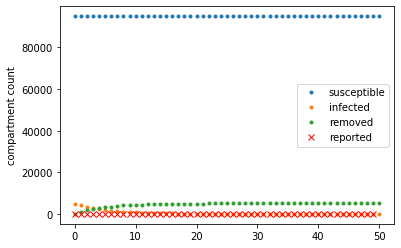

In [619]:
with numpyro.handlers.seed(rng_seed=6):
    X, y = SIR_stochastic(dt=1.0, steps=50, N=1e5)

y = np.cumsum(y)
fig, ax1 = plt.subplots(figsize=(6,4))

l1 = ax1.plot(X, '.')
ax1.set_ylabel('compartment count')

plotyy = False
if plotyy:
    ax2 = ax1.twinx()
    l2 = ax2.plot(y, 'x', color='r')    
else:
    l2 = ax1.plot(y, 'x', color='r')
    ax2.set_ylabel('confirmed cases', color='r')
    ax2.spines['right'].set_color('r')
    ax2.yaxis.label.set_color('r')
    ax2.tick_params(axis='y', colors='r')

plt.legend(l1 + l2, ['susceptible', 'infected', 'removed', 'reported'])

plt.show()

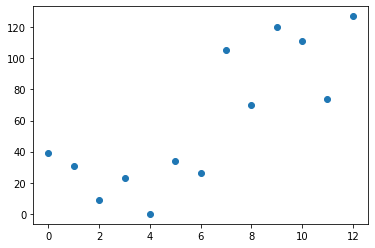

In [544]:
positive = get_data('WA')
new_pos = np.diff(np.hstack((0, positive)))
plt.plot(new_pos, 'o')
plt.show()




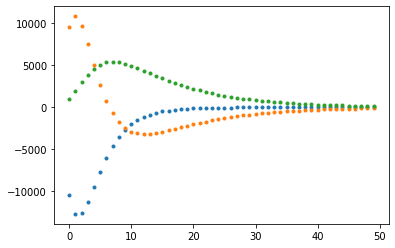

In [428]:
plt.plot(np.diff(X, axis=0), '.')

In [540]:
def get_data(state='MA'):
    df = pd.read_csv('states-daily.csv')
    df.date = pd.to_datetime(df.date, format='%Y%m%d')
    df = df.set_index('date')
    df = df.sort_index()
    return df[df.state==state].positive.sort_index()
    
positive = get_data('WA')

date
2020-03-04     39.0
2020-03-05     70.0
2020-03-06     79.0
2020-03-07    102.0
2020-03-08    102.0
2020-03-09    136.0
2020-03-10    162.0
2020-03-11    267.0
2020-03-12    337.0
2020-03-13    457.0
2020-03-14    568.0
2020-03-15    642.0
2020-03-16    769.0
Name: positive, dtype: float64

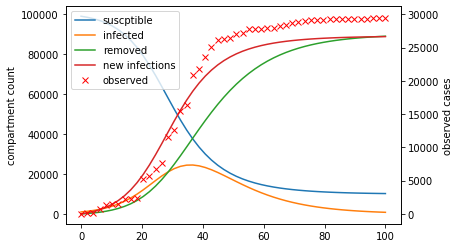

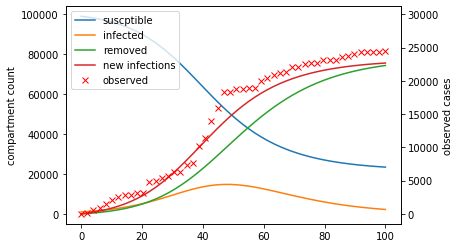

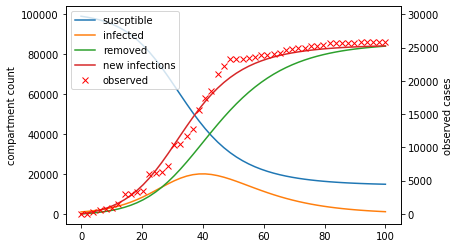

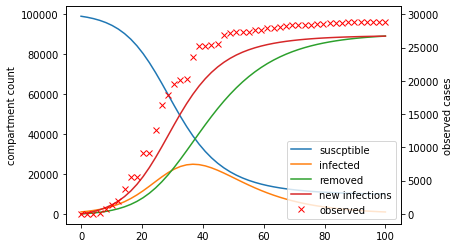

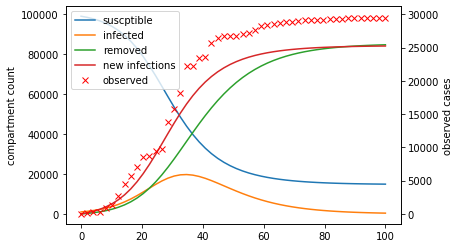

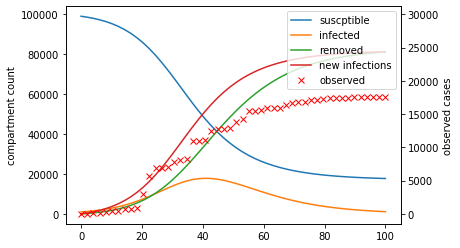

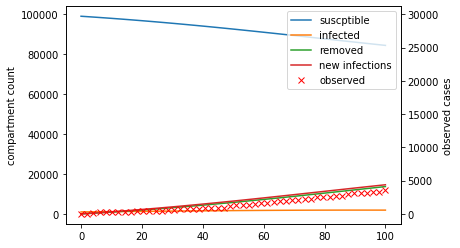

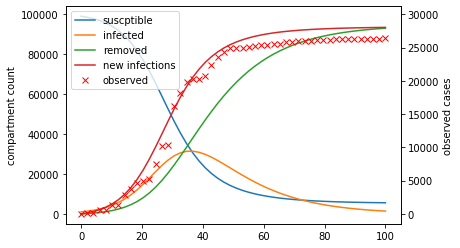

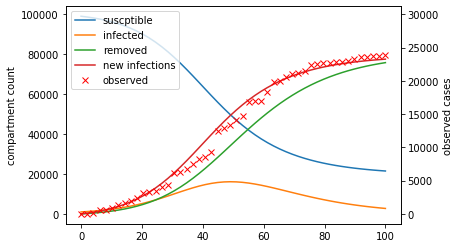

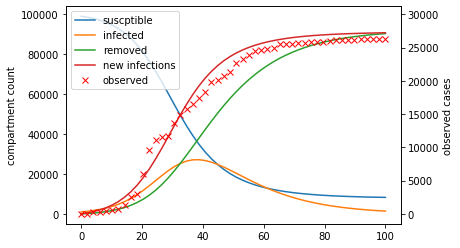

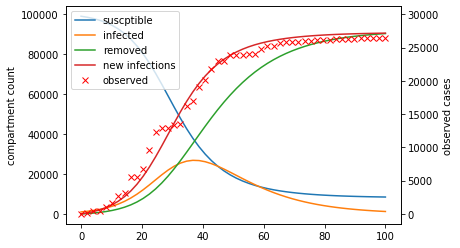

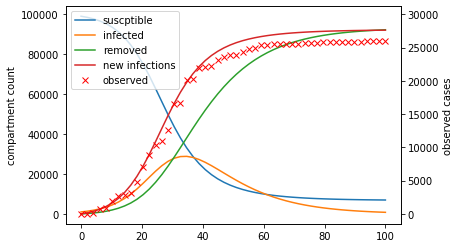

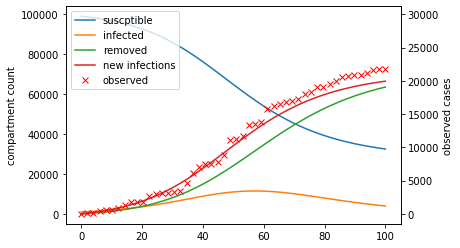

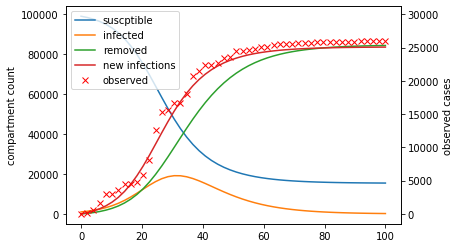

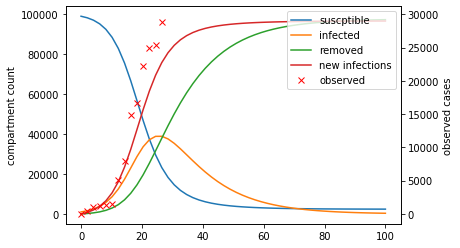

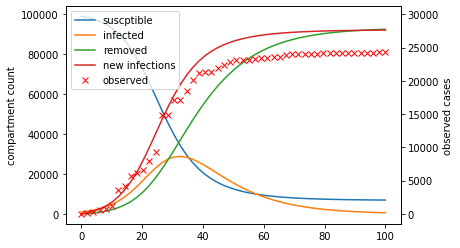

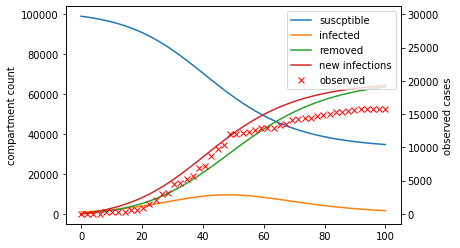

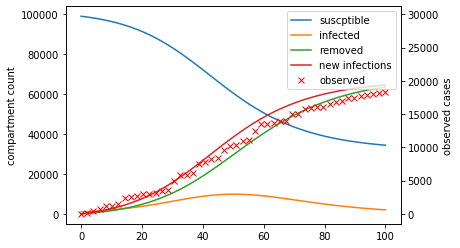

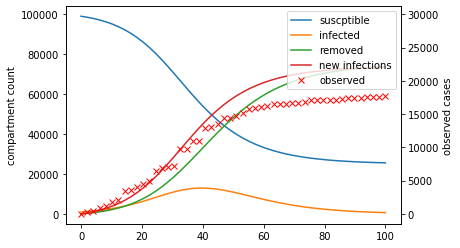

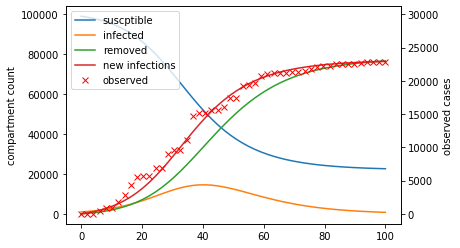

In [605]:
def model1(ts=None, N=1e5):
    '''
    Model with random parameters and observation, deterministic dynamics
    '''
    x_init = N * np.array([0.99, 0.01, 0.00, 0.00])

    beta_mean = 2.2/10
    beta_scale = 0.2 * beta_mean
    
    gamma_mean = 1/10
    gamma_scale = 0.2 * gamma_mean
        
    obs_rate = 0.3
    obs_concentration = 2
    
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(low=0., 
                             loc=np.array([beta_mean, gamma_mean]),
                             scale=np.array([beta_scale, gamma_scale])))

    x = SIR_int(x_init, ts, *theta)
    numpyro.deterministic("x", x)
        
    new_infections = np.diff(np.hstack((0, x[:,3])))
    
    T = len(new_infections)
    
    obs_fractions = numpyro.sample('obs_frac',
                                    dist.Beta(obs_rate * obs_concentration,
                                              (1-obs_rate) * obs_concentration),
                                    sample_shape=(T,))

    y = new_infections * obs_fractions
    
    return x, y

def test_model1(i):
    ts = np.linspace(0.0, 100, 50)
    with numpyro.handlers.seed(rng_seed=i):
        x, y = model1(ts)

    y_cum = np.cumsum(y)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    l1 = ax1.plot(ts, x)
    l2 = ax2.plot(ts, y_cum, 'x', color='r')
    
    plt.legend(l1 + l2, ['suscptible', 'infected', 'removed', 'new infections', 'observed'])
    
    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    ylim = np.array(ax1.get_ylim())
    obs_rate = 0.3
    ax2.set_ylim( obs_rate * ylim )
    
    plt.show()

for i in range(20):
    test_model1(i)

[[99000.       1000.          0.          0.     ]
 [98560.445    1177.7798    261.9608    439.73965]
 [98045.35     1384.4573    570.1923    954.6493 ]
 [97444.2      1623.6968    932.09784  1555.7921 ]
 [96744.8      1899.2112   1355.9772   2255.1887 ]
 [95934.31     2214.6406   1851.0203   3065.6624 ]
 [94999.49     2573.2444   2427.2405   4000.489  ]
 [93926.97     2977.6418   3095.393    5073.035  ]
 [92703.766    3429.4888   3866.7573   6296.246  ]
 [91318.41     3928.8386   4752.757    7681.595  ]
 [89761.484    4473.8423   5764.671    9238.513  ]
 [88026.59     5060.244    6913.16    10973.404  ]
 [86111.72     5680.8945   8207.376   12888.273  ]
 [84020.24     6325.525    9654.199   14979.734  ]
 [81761.08     6980.904   11258.024   17238.928  ]
 [79349.73     7630.7236  13019.565   19650.287  ]
 [76808.375    8256.403   14935.249   22191.646  ]
 [74164.01     8839.075   16996.97    24836.033  ]
 [71448.26     9359.676   19192.07    27551.746  ]
 [68696.13     9800.359   21503

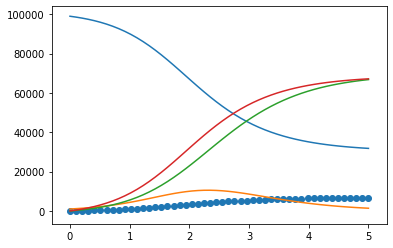

In [580]:
ts = np.linspace(0.0, 5.0, 50)
with numpyro.handlers.seed(rng_seed=i):
    x, y = model1(ts)
    print(x, y)

y_cum = np.cumsum(y)

plt.plot(ts, x)
plt.scatter(ts, y_cum)
plt.show()


In [ ]:
# Samples from the prior predictive

ts = np.linspace(0.0, 5.0, 20)
prior_predictive = Predictive(model1, posterior_samples = {}, num_samples=100)
samples = prior_predictive(PRNGKey(2), ts)
mean = samples['x'].mean(axis=0)
pi = np.percentile(samples['x'], (10, 90), axis=0)

#plt.plot(ts, mean[:,1], color='g')
plt.plot(ts, mean[:,1], color='r')
plt.plot(ts, mean[:,2], color='b')

plt.scatter(ts, samples['y'])

#plt.fill_between(ts, pi[0, :, 0], pi[1, :, 0], color="g", alpha=0.1)
plt.fill_between(ts, pi[0, :, 1], pi[1, :, 1], color="r", alpha=0.1)
plt.fill_between(ts, pi[0, :, 2], pi[1, :, 2], color="b", alpha=0.1)

plt.legend(['infected', 'removed'])

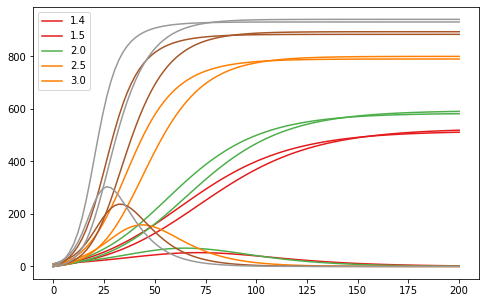

In [579]:
# run the deterministic model
ts = np.linspace(0.0, 200.0, 100)
gamma = 1/10

R0_vals = [1.4, 1.5, 2.0, 2.5, 3.0]

n = len(R0_vals)
color=iter(cm.Set1(np.linspace(0,1,n)))

plt.figure(figsize=(8,5))
for R0 in R0_vals:
    beta = R0*gamma
    c = next(color)
    x = model_deterministic(ts, beta, gamma, N=1e3)
    plt.plot(ts, x[:,1:], color=c)

plt.legend(plt.gca().lines[::2], R0_vals)
plt.show()

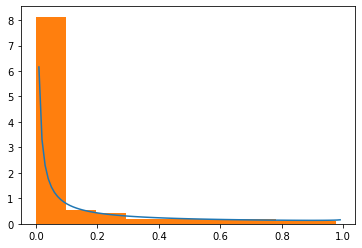

In [117]:
def myBeta(mean, concentration):
    alpha = mean * concentration
    beta = concentration - alpha
    return dist.Beta(alpha, beta)

d = myBeta(0.1, 1)
x = np.linspace(0, 1, 100)
plt.plot(x, np.exp(d.log_prob(x)))

with numpyro.handlers.seed(rng_seed=1):
    x = numpyro.sample('x', d, sample_shape=(1000,))

plt.hist(x, density=True)
plt.show()

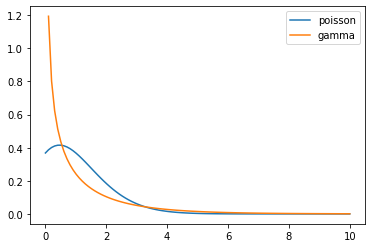

In [69]:
rate = 1
d_pois = dist.Poisson(rate)
beta = 0.5
d_gamma = dist.Gamma(rate*beta, beta)
#d_normal = dist.Normal(rate, np.sqrt(rate))
# with numpyro.handlers.seed(rng_seed=1):
#     x = numpyro.sample('x', d, sample_shape=(1000,))

x = np.linspace(0, 10, 100)
plt.plot(x, np.exp(d_pois.log_prob(x)))
plt.plot(x, np.exp(d_gamma.log_prob(x)))
#plt.plot(x, np.exp(d_normal.log_prob(x)))
plt.legend(['poisson', 'gamma', 'normal'])

In [ ]:
d = dist.Beta(50, 1)
x = np.linspace(0, 1, 100)
plt.plot()